Title: Les séries temporelles avec Python (4/4) - Analyse et modélisation
Author: Louis
Date: '2022-11-08'
Slug: timeseries-3
Category: Python
Tags: Python, Machine Learning, Statistiques, Data Science, Séries temporelles, Datetime
Cover: images/cover_6.png
Summary: Analyse d'une série temporelle par décomposition et modélisations classiques.

[TOC]

>1. Introduction à la manipulation de données temporelles avec Python
>2. Visualisation et opérations sur les séries temporelles
>3. Éléments théoriques et exemples
>4. **Analyse, modélisation et prédiction**

Après une toute petite ellipse temporelle de plus d'un an, ce quatrième post s'attaque au vrai problème à savoir la décomposition, la modélisation et la prédiction des séries temporelles à l'aide des modèles statistiques classiques.

## Décomposition d'une série temporelle

Le principe de la décomposition des séries temporelles est de découper les séries originales en plusieurs composants indépendants (vus dans le post précédent) : tendance, saisonnalité, cycle et bruit.

Pour illustrer tout ça, on va utiliser des données qui sont aux séries temporelles ce que le dataset "Titanic" est au machine learning : la série AirPassenger qui mesure le nombre mensuel de passagers aériens, en milliers, de janvier 1949 à décembre 1960.

Dans la suite, on va noter $X_{t}$  la série AirPassengers et $Y_t=ln(X_t)$. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fonctions as fct

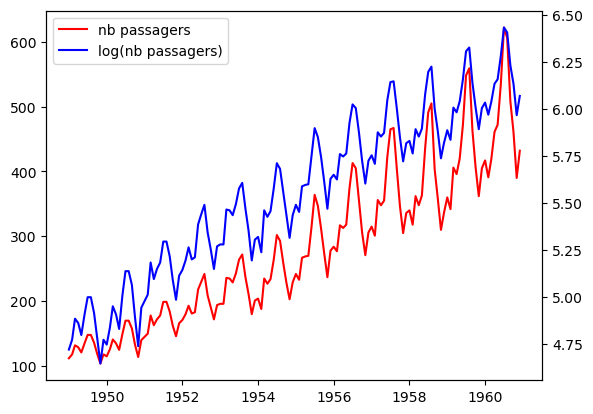

In [2]:
x = pd.read_csv('data/AirPassengers.csv', index_col=0, parse_dates=True)
y = np.log(x)

# création d'un graphique avec la série originale
fig, ax = plt.subplots()
ln1 = ax.plot(x, c='r', label="nb passagers")

# création d'un graphique avec la série log en conservent le même axe des abscisses
ax2 = ax.twinx()
ln2 = ax2.plot(y, c='b', label="log(nb passagers)")

# ajout de la légende
lns = ln1 + ln2
labels=[l.get_label() for l in lns]
ax.legend(lns, labels);

Comme $log(ab) = log(a) + log(b)$ donc le $log$ transforme un modèle **multiplicatif** en un modèle **additif**. Ainsi l'accroissement de l'amplitude des pics (donc de la variance) pour la série $X$ disparaît avec la transformation logarithmique.  

### La tendance

On a présenté dans le premier post une façon de visualiser la tendance en lissant la courbe à l'aide des moyennes mobiles sur une fenêtre glissante d'observations. Lorsqu'on choisit différentes tailles de fenêtres glissantes, on obtient les résultats suivants.

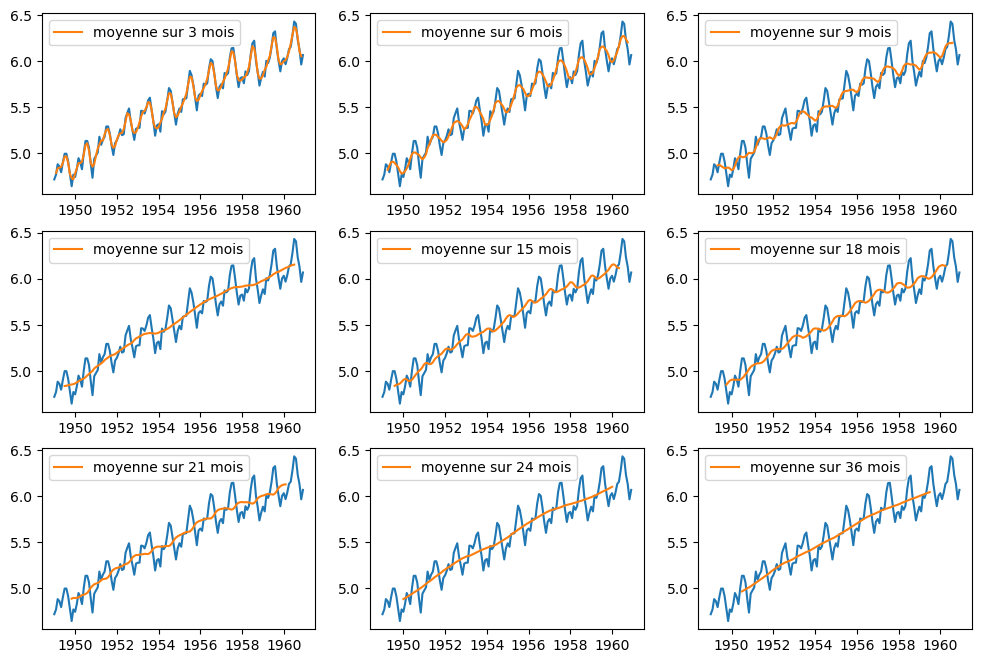

In [5]:
win = [3, 6, 9, 12, 15, 18, 21, 24, 36]
fig = plt.figure(figsize=(12,8))

for i in range(len(win)):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(y)
    ax.plot(y.rolling(win[i], center=True).mean(), label=f"moyenne sur {win[i]} mois")
    ax.legend()

En prenant une fenêtre de 12, 24 ou 36 mois, une tendance linéaire et croissante est bien visible. Par ailleurs, cette tendance étant identifiable pour des fenêtres glissantes dont la taille est un multiple de 12 mois pointe vers la notion de saisonnalité. On sait peut-être plus ce que c'est, mais en tout cas, il se passe un truc tous les 12 mois...

### La saisonnalité

La saisonnalité désigne les tendances hebdomadaires, mensuelles, trismestrielles ou annuelles. Ce sont les motifs qui se répètent sur une durée infra-annuelle. Il semble qu'on ait ici une saisonnalité annuelle. Une manière visuelle de vérifier l'effet saisonnier est de tracer une courbe pour chaque année en prenant les mois comme abscisses et visualiser ainsi la répartition des passagers au cours de chaque année.

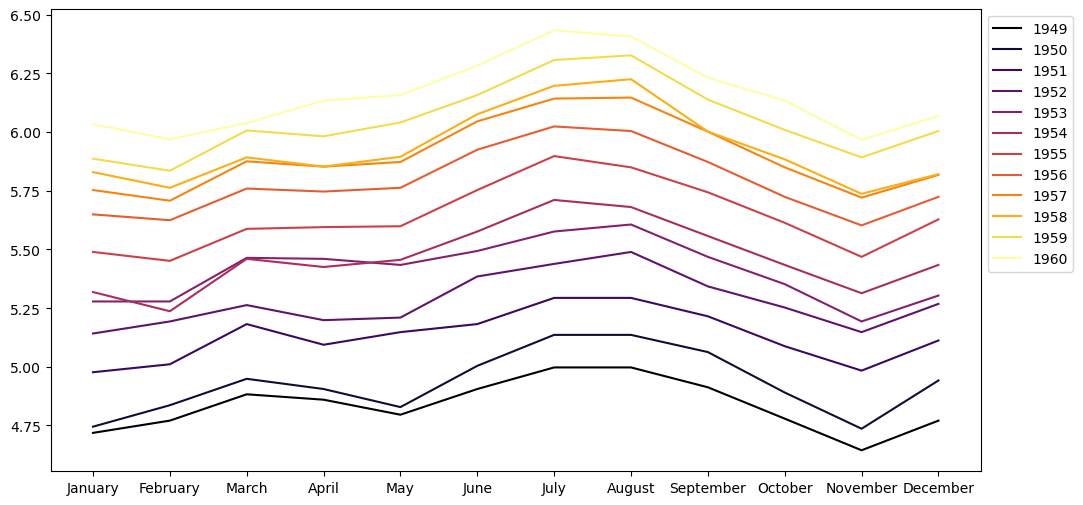

In [10]:
plt.figure(figsize=(12, 6))

yrs = [str(yr) for yr in y.index.year.unique()]
mths = y.index.month_name().unique()
colors = plt.cm.inferno(np.linspace(0,1,len(yrs)))

for i in range(len(yrs)):
    plt.plot(mths, y.loc[yrs[i]], label=yrs[i], color=colors[i])
    plt.legend(bbox_to_anchor=(1,1))

Ça confirme bien l'intuition et en plus c'est joli.

### Le bruit

Il ne reste plus qu'à identifier ce qui reste : le bruit. On l'obtient donc en soustrayant (dans un modèle additif !) à la série originale les tendance et saisonnalité. Au final, voilà une série décomposée.

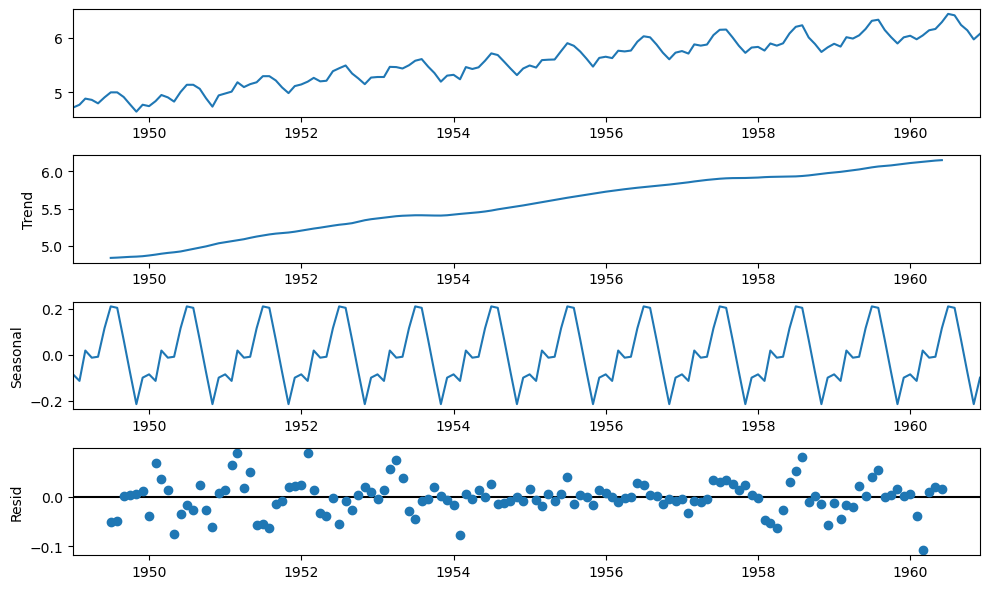

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

decomp = seasonal_decompose(y, model='additive')

fig = decomp.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

## Prévision avec un lissage exponentiel

Le lisage exponentiel est une technique de lissage qui ressemble un peu aux moyennes mobiles et peut être utilisée pour prédire une série temporelle. C'est en fait un cas particulier des modèles ARMA déjà évoqués. On en distingue différents types (simple, double, triple...). On notera que les lissages exponentiels simple et double ne sont plus vraiment d'actualité donc on présente juste le lissage exponentiel triple, qui lui, est parfois utilisé.

Le lissage exponentiel triple ou méthode de Holt-Winters est adapté à des séries à tendance localement linéaire avec en plus une composante saisonnière. Ce qui est le cas de notre série logarithmique.

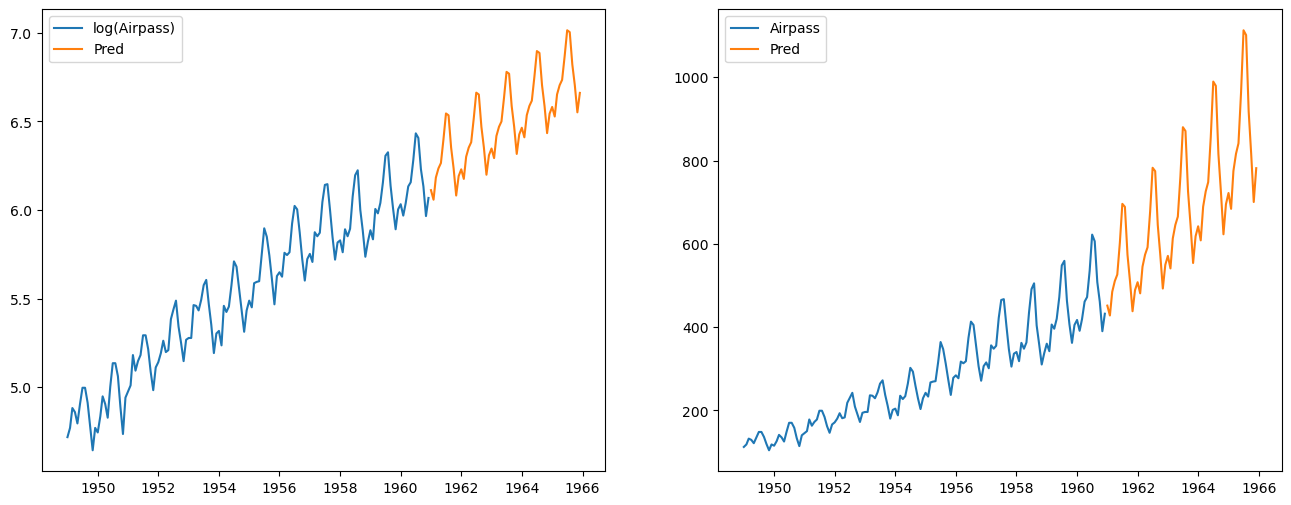

In [25]:
from statsmodels.tsa.api import ExponentialSmoothing

let = ExponentialSmoothing(y.values, seasonal_periods=12, trend='add', seasonal='add').fit()

y_pred = let.forecast(60)# prédiction pour la série log
x_pred = np.exp(let.forecast(60)) # récupération des prédiction pour la série originale

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

ax1.plot(y, label='log(Airpass)')
ax1.plot(pd.date_range(y.index[len(y)-1], periods=60, freq='M'), y_pred, label='Pred')
ax1.legend()

ax2.plot(x, label='Airpass')
ax2.plot(pd.date_range(y.index[len(y)-1], periods=60, freq='M'), x_pred, label='Pred')
ax2.legend()

plt.show()

## Prévision à l'aide d'un modèle ARIMA

Un modèle autoréfressif intégré à moyennes mobiles (ARIMA) est une généralisation du modèle ARMA, aperçu dans le post précédent. 

Les modèles ARIMA sont appliqués dans certains cas où les données montrent une non-stationnarité. Une étape de différenciation initiale (correspondant à la partie "intégrée" du modèle) peut alors être appliquée une ou plusieurs fois pour éliminer la non-stationnarité.

Dans le modèle de base, trois paramètres $(p,d,q)$ sont utilisés pour paramétrer les modèles ARIMA. Par conséquent, un modèle ARIMA est noté $ARIMA(p,d,q)$ et est défini par :
$$
\left(1 - \sum_{i=1}^p \phi_i L^i \right) (1 - L)^d y_t = \mu + \left(1 + \sum_{i=1}^q \theta_i L^i \right) \varepsilon_t
$$

Une généralisation est le modèle SARIMA, ou ARIMA saisonnier, qui permet de tenir compte en plus de la saisonnalité. Ce modèle est caractérisé non plus par 3 paramètres $(p,d,q)$ mais par 7 ! Le modèle SARIMA noté $SARIMA(p,d,q)(P,D,Q)_s$ où :
- $s$ est la période de la saisonnalité
- $(P,D,Q)$ sont les ordres de la partie saisonnière

Sans entrer dans trop de détails théoriques, on va regarder un peu en pratique.

### Stationnarisation de la série

Les séries ont généralement une tendance et une saisonnalité. Pour pouvoir les modéliser par des processus stationnaires comme les ARMA, il faut les stationnariser. On va voir en pratique comment faire.

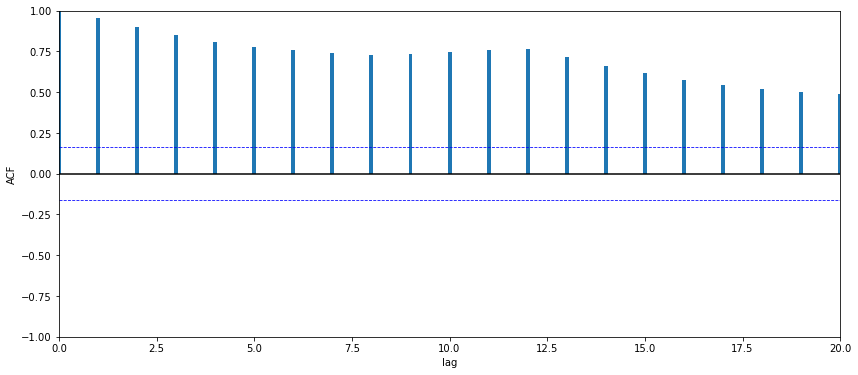

In [20]:
fct.plot_acf_pacf(y)

La sortie ACF présente une décroissance lente vers 0, ce qui traduit un problème de non-stationnarité. On effectue donc une différenciation $(1-L)$ c'est-à-dire qu'on va regarder la série $Y_t-Y_{t-1}$.

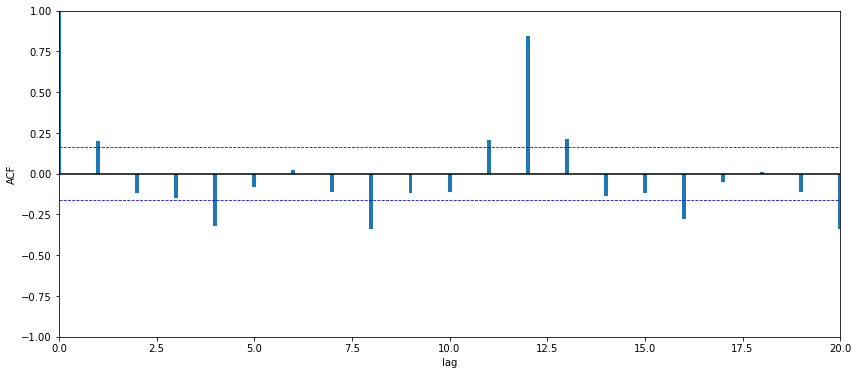

In [21]:
y_diff_1 = y - y.shift(1)
fct.plot_acf_pacf(y_diff_1[1:])

Toujours une décroissance lente vers 0 de la série différenciée d'ordre 1 **pour les multiples de 12**. Cela correspond à la saisonnalité et on va donc différencier à nouveau en appliquant cette fois $(1-L^{12})$ .

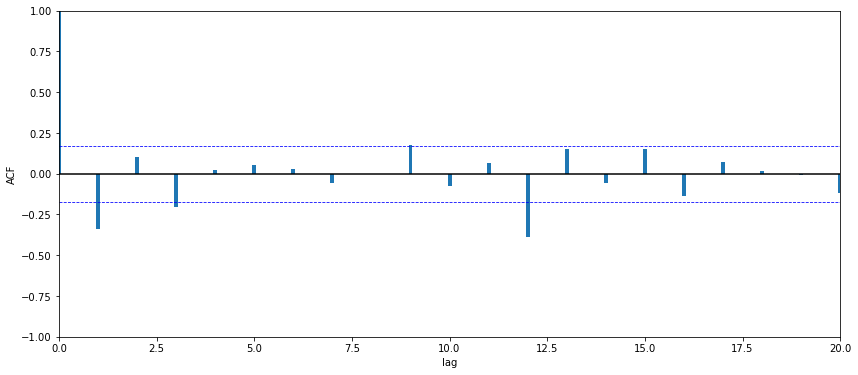

In [22]:
y_diff_1_12 = y_diff_1 - y_diff_1.shift(12)
fct.plot_acf_pacf(y_diff_1_12[13:])

Avec cette double différenciation, on s'approche d'un autocorrélogramme simple empirique. On va donc modéliser la série $(1-L)(1-L^{12})ln(X_t)$ par un modèle ARMA.

### **5.2. Identification, estimation et validation de modèles**

On va s'appuyer sur les sorties ACF et PACF donc on peut utiliser une des fonctions disponibles dans `fonctions.py` par exemple `ts_plot` pour changer.

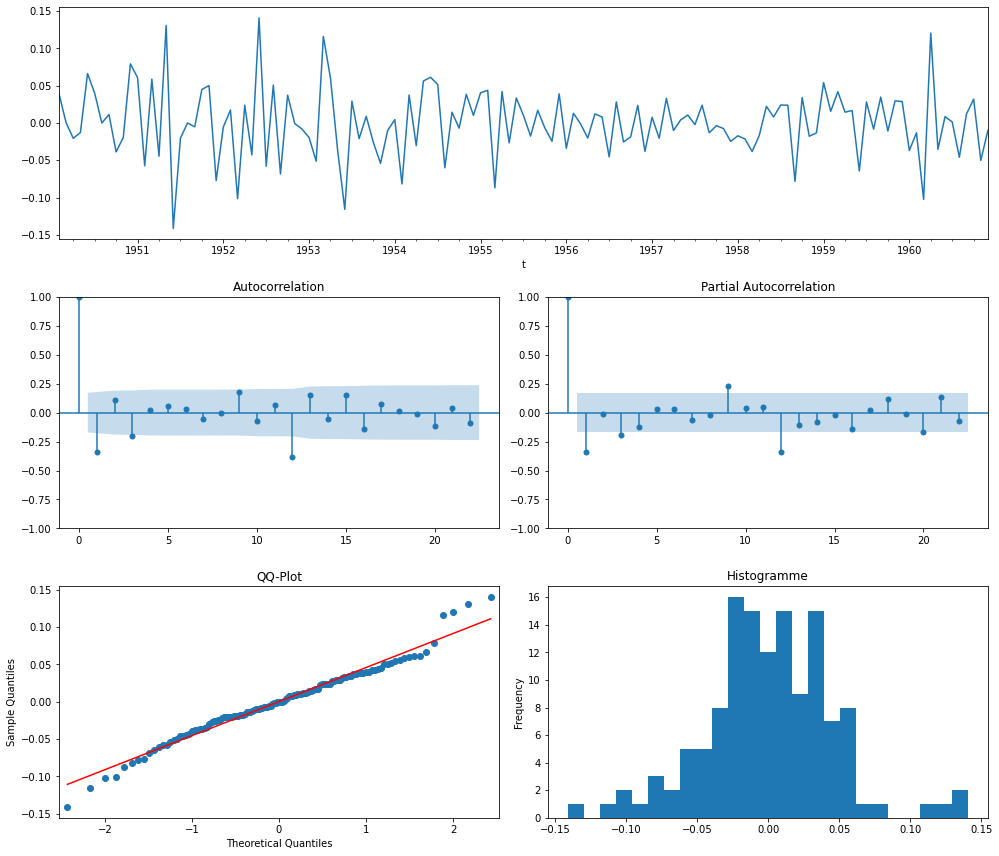

In [24]:
fct.ts_plot(y_diff_1_12[13:].Airpass)

Les graphiques ACF et PACF permettent de voir empiriquement qu'on va avoir un modèle $SARIMA(p,d,q)(P,D,Q)_s$ avec $s=12$. On va tester différents modèles.

**Modèle 1 :** pour commencer on va prendre un $SARIMA(1,1,1)(1,1,1)_{12}$ qui s'écrit :
$$(1-\phi_{1}L)(1-\phi'_{1}L^{12})(1-L)(1-L^{12})ln(X_{t})=(1+\theta_{1}L)(1+\theta'_{1}L^{12})\epsilon_{t} $$

In [28]:
from statsmodels.tsa.statespace.sarimax import *

m1 = SARIMAX(y.values, order=(1,1,1), seasonal_order=(1,1,1,12))
res1 = m1.fit(disp=False)
print(res1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 245.152
Date:                            Wed, 29 Jun 2022   AIC                           -480.304
Time:                                    10:41:40   BIC                           -465.928
Sample:                                         0   HQIC                          -474.462
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1701      0.212      0.801      0.423      -0.246       0.586
ma.L1         -0.5649      0.184   

Ce modèle a des coefficients non significatifs, on en teste un second en retirant dans le paramètre associé à la plus grande p-value : ici c'est le terme autorégressif saisonnier.

**Modèle 2 :** on va donc prendre un $SARIMA(1,1,1)(0,1,1)_{12}$ qui s'écrit :
$$(1-\phi_{1}L)(1-L)(1-L^{12})ln(X_{t})=(1+\theta_{1}L)(1+\theta'_{1}L^{12})\epsilon_{t} $$

In [29]:
m2 = SARIMAX(y.values, order=(1,1,1), seasonal_order=(0,1,1,12))
res2 = m2.fit(disp=False)
print(res2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.945
Date:                            Wed, 29 Jun 2022   AIC                           -481.890
Time:                                    10:41:57   BIC                           -470.389
Sample:                                         0   HQIC                          -477.217
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1841      0.201      0.915      0.360      -0.210       0.578
ma.L1         -0.5667      0.174   

Ce modèle a toujours un coefficient non significatif, on en teste un 3ème modèle en retirant dans le terme autorégressif d'ordre 1.

**Modèle 3 :** on va donc prendre un $SARIMA(0,1,1)(0,1,1)_{12}$ qui s'écrit :
$$(1-L)(1-L^{12})ln(X_{t})=(1+\theta_{1}L)(1+\theta'_{1}L^{12})\epsilon_{t} $$

In [30]:
m3 = SARIMAX(y.values, order=(0,1,1), seasonal_order=(0,1,1,12))
res3 = m3.fit(disp=False)
print(res3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Wed, 29 Jun 2022   AIC                           -483.393
Time:                                    10:42:34   BIC                           -474.767
Sample:                                         0   HQIC                          -479.888
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4013      0.073     -5.496      0.000      -0.544      -0.258
ma.S.L12      -0.5566      0.096   

Cette fois tous les coefficients sont significatifs, il faut encore tester ce qu'on appelle la "blancheur" des résidus : on veut avoir des résidus qui sont un bruit blanc (faible), c'est-à-dire, entre autres qu'ils sont non corrélés.  
Pour ça on peut utiliser le test de Ljung-Box d'autocorrélation des résidus qui est implémenté dans la fonction `acorr_ljungbox` de `statsmodels.stats.diagnostic` 

In [35]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print('Retard : p-value')
for lag in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(lag, acorr_ljungbox(res3.resid, lags=lag, return_df=False)[1].mean()))

Retard : p-value
6 : 0.981720860200859
12 : 0.9083064612785483
18 : 0.6207396507474344
24 : 0.5187361239841579
30 : 0.5161804687133994
36 : 0.560395354197207


Toutes les p-values sont élevées ce qui signifie qu'on ne peut pas rejeter l'hypothèse nulle du test. Or, l'hypothèse $H_0$ est qu'il n'y a pas d'autocorrélation des résidus, on peut pas la rejeter, donc on est bon !

On peut enfin tester la normalité des résidus avec le test de Shapiro-Wilk implémenté dans la fonction `scipy.stats.shapiro`, l'hypothèse nulle étant que les étant que les observations sont normalement distribuées, on souhaite encore une fois une p-value élevée pour ne pas rejeter $H_0$.

In [36]:
from scipy.stats import shapiro
shapiro(res3.resid[13:])

ShapiroResult(statistic=0.9908484220504761, pvalue=0.547280490398407)

Le test de normalité est également validé pour ce modèle et on peut afficher les résidus pour le visualiser :

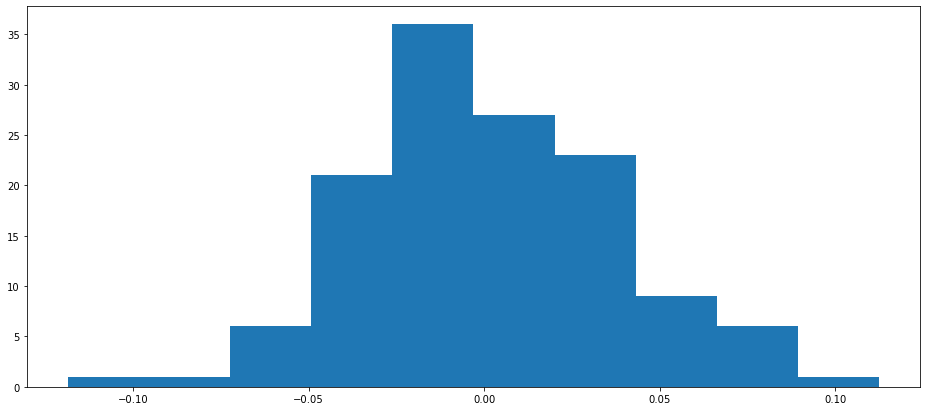

In [37]:
plt.hist(res3.resid[13:], bins=10);

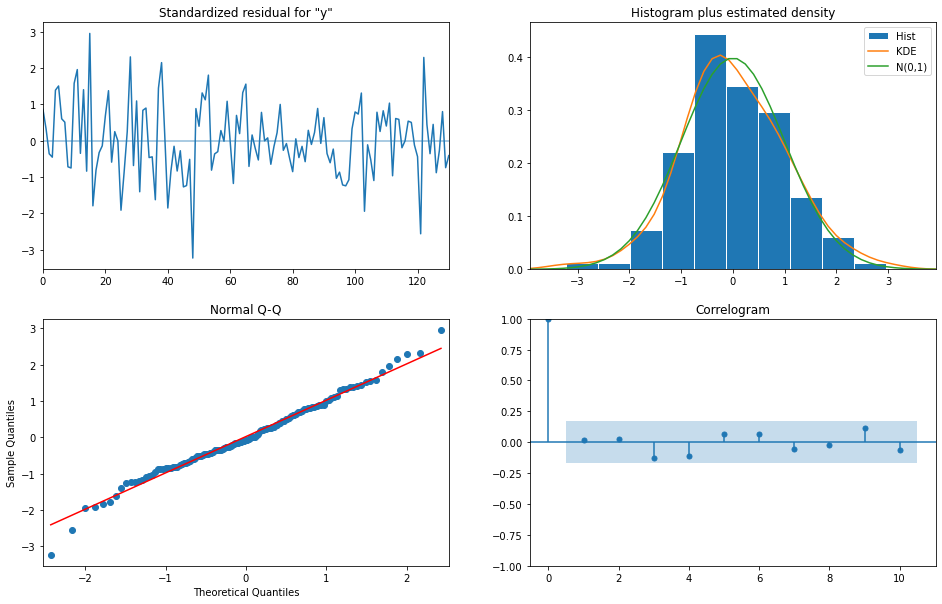

In [38]:
# autre méthode d'affichage des résultats
# attention, ce sont les résidus standardisés par contre donc pas exactement les mêmes que ceux affichés au dessus.
res3.plot_diagnostics(figsize=(16, 10));

### **5.3. Prévision de l’année 1961 avec le modèle retenu**

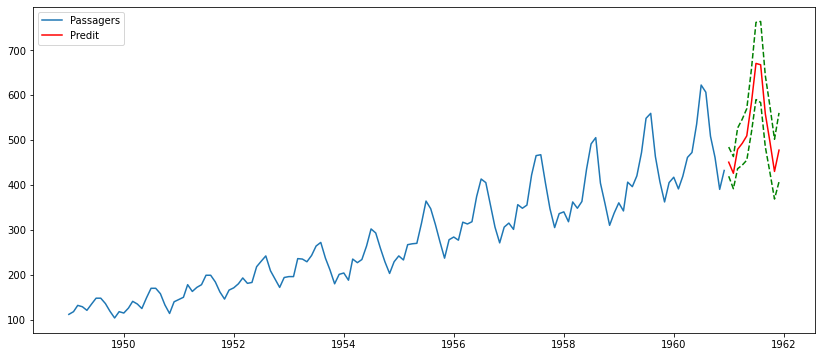

In [39]:
# prédiction et intervalles de confiance
y_pred = res3.get_forecast(12)
x_pred = np.exp(y_pred.predicted_mean)
x_pred_inf = [np.exp(p[0]) for p in y_pred.conf_int(alpha=0.05)]
x_pred_sup = [np.exp(p[1]) for p in y_pred.conf_int(alpha=0.05)]

# affichage
plt.figure(figsize=(14,6))
plt.plot(x.index, x.values, label='Passagers')
plt.plot(pd.date_range(x.index[-1], periods=12, freq='M'), x_pred, color='r', label='Predit')
plt.plot(pd.date_range(x.index[-1], periods=12, freq='M'), x_pred_inf, color='g', linestyle='--')
plt.plot(pd.date_range(x.index[-1], periods=12, freq='M'), x_pred_sup, color='g', linestyle='--')
plt.legend()
plt.show()

### **5.4. Évaluation de la qualité prédictive du modèle**

On a pas eu vraiment besoin de le faire jusqu'à maintenant mais, vous le savez, pour pouvoir faire un modèle prédictif, il faut mettre en place, entraîner, tester et évaluer votre modèle. Pour cela, il faut découper nos données en training et test sets.

**Exo :** splitter en training et test sets en tronquant la série en 1959 pour pouvoir ensuite prédire l'année 1960

In [67]:
# on fait pas un train_test_split mais on tronque la série car on veut pas des valeurs réparties aléatoirement :
# on veut tous les points jusqu'à une certaine date pour prédire ceux qui suivent

# série x : série des passagers
x_train = x.loc[:'1959', 'Airpass']
x_test = x.loc['1960':, 'Airpass']

# série y=log(x) : transformation logarithmique de la série des passagers 
y_train = y.loc[:'1959', 'Airpass']
y_test = y.loc['1960':, 'Airpass']

**Exo :** vérifier que le modèle retenu précédemment est toujours valide sur la série tronquée "y_train"

In [68]:
# modélisation et summary
model = SARIMAX(y_train.values, order=(0,1,1), seasonal_order=(0,1,1,12))
res = model.fit(disp=False)
print(res.summary())

# test d'autocorrélation des résidus
print('Retard : p-value')
for lag in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(lag, acorr_ljungbox(res.resid, lags=lag, return_df=False)[1].mean()))
    
# test de normalité des résidus
shapiro(res.resid[13:])

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 223.627
Date:                            Wed, 29 Jun 2022   AIC                           -441.253
Time:                                    11:00:28   BIC                           -432.916
Sample:                                         0   HQIC                          -437.868
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3488      0.081     -4.303      0.000      -0.508      -0.190
ma.S.L12      -0.5621      0.094   

ShapiroResult(statistic=0.9925785064697266, pvalue=0.7792742252349854)

**Exo :** prédire les valeurs des années 1959 et 1960 et afficher sur un même graphique les valeurs réelles, prédites et les intervalles de confiance

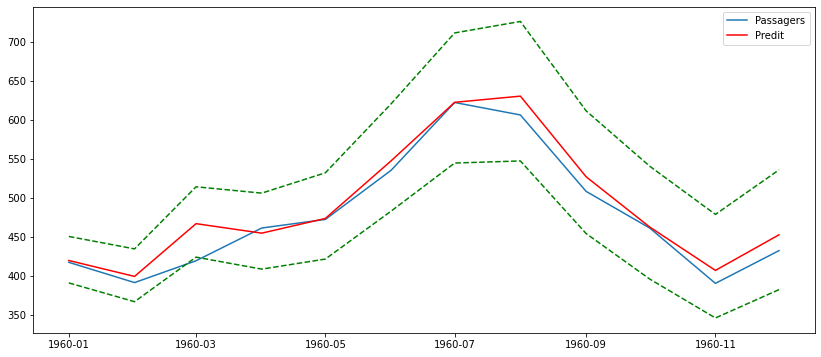

In [69]:
# prédiction et intervalles de confiance
y_pred = res.get_forecast(len(y_test))
x_pred = np.exp(y_pred.predicted_mean)
x_pred_inf = [np.exp(p[0]) for p in y_pred.conf_int(alpha=0.05)]
x_pred_sup = [np.exp(p[1]) for p in y_pred.conf_int(alpha=0.05)]

# affichage
plt.figure(figsize=(14,6))
plt.plot(x_test.index, x_test.values, label='Passagers')
plt.plot(x_test.index, x_pred, color='r', label='Predit')
plt.plot(x_test.index, x_pred_inf, color='g', linestyle='--')
plt.plot(x_test.index, x_pred_sup, color='g', linestyle='--')
plt.legend()
plt.show()

**Exo :** calculer les 2 métriques RMSE et MAPE pour ces prédictions

In [70]:
rmse = np.sqrt(((x_test-x_pred)**2).mean())
mape = (np.abs(1-x_pred/x_test)).mean()*100
print("RMSE = {} et MAPE = {}".format(rmse, mape))

RMSE = 18.59230984670951 et MAPE = 2.90416326714094


**Exo :** répeter les opérations du point 5.4 en modifiant la troncature : training set avec les données jusqu'en 1958 pour prédire un test set avec les années 1959 et 1960

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 197.505
Date:                            Wed, 29 Jun 2022   AIC                           -389.010
Time:                                    11:01:23   BIC                           -380.991
Sample:                                         0   HQIC                          -385.759
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3422      0.087     -3.921      0.000      -0.513      -0.171
ma.S.L12      -0.5407      0.105   

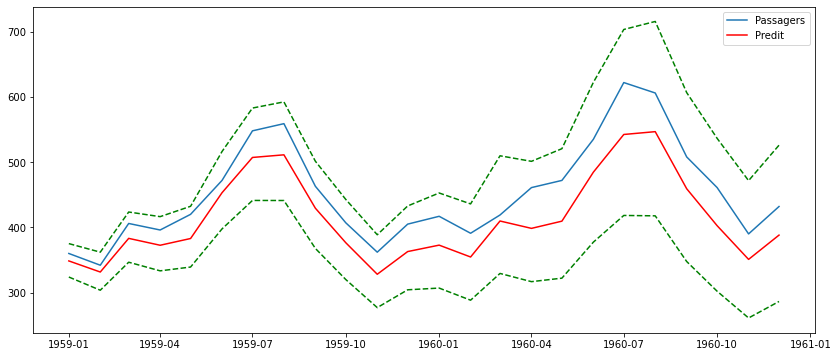

RMSE = 43.18024430485034 et MAPE = 8.51556515346472


In [72]:
x_train = x.loc[:'1958', 'Airpass']
x_test = x.loc['1959':, 'Airpass']
y_train = y.loc[:'1958', 'Airpass']
y_test = y.loc['1959':, 'Airpass']

# modélisation et summary
model = SARIMAX(y_train.values, order=(0,1,1), seasonal_order=(0,1,1,12))
res = model.fit(disp=False)
print(res.summary())

# test d'autocorrélation des résidus
print('Retard : p-value')
for lag in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(lag, acorr_ljungbox(res.resid, lags=lag, return_df=False)[1].mean()))
    
# test de normalité des résidus
print(shapiro(res.resid[13:]))

# prédiction et intervalles de confiance
y_pred = res.get_forecast(len(y_test))
x_pred = np.exp(y_pred.predicted_mean)
x_pred_inf = [np.exp(p[0]) for p in y_pred.conf_int(alpha=0.05)]
x_pred_sup = [np.exp(p[1]) for p in y_pred.conf_int(alpha=0.05)]

# affichage
plt.figure(figsize=(14,6))
plt.plot(x_test.index, x_test.values, label='Passagers')
plt.plot(x_test.index, x_pred, color='r', label='Predit')
plt.plot(x_test.index, x_pred_inf, color='g', linestyle='--')
plt.plot(x_test.index, x_pred_sup, color='g', linestyle='--')
plt.legend()
plt.show()

# évaluation de la qualité de prédiction
rmse = np.sqrt(((x_test-x_pred)**2).mean())
mape = (np.abs(1-x_pred/x_test)).mean()*100
print("RMSE = {} et MAPE = {}".format(rmse, mape))

### **5.5. Une autre approche pour la détermination du modèle**

Pour adapter les données de série temporelles à un modèle ARIMA saisonnier avec les paramètres $SARIMA(p,d,q)(P,D,Q)s$, on doit trouver les paramètres optimaux et pour ça on peut aussi faire de la recherche sur grille qui consiste à tester de manière itérative plusieurs valeurs possibles des paramètres et d'évaluer les modèles en utilisant des critères comme le critère AIC ou BIC.

On utilisera nous le critère d'information Akaike ($AIC$) qui mesure la qualité relative des modèles statistiques pour un ensemble d'observations donné. À partir d'un ensemble de modèles, le critère $AIC$ permet d'estime la qualité de chacun des modèle par rapport aux autres modèles. Cela permet donc de sélectionner des modèles. Intuitivement, le critère $AIC$ mesure le compromis entre la qualité de l'ajustement du modèle aux observations fournies et la complexité du modèle (nombre de paramètres inclus et estimés). Le critère $AIC$ est calculé par :

$AIC=2k-2ln(L)$ avec :
- $k$ nombre de paramètres estimés
- $L$ valeur maximale de la vraisemblance (pour simplifier maximiser la vraisemblance revient plus ou moins à minimiser l'erreur)

Le meilleur modèle est celui qui minimise le critère $AIC$.

**Exo :** on continue à modéliser la série logarithmique. Tronquer la série en 1958 (inclus) pour prédire 1959 et 1960

In [81]:
x_train = x.loc[:'1958', 'Airpass']
x_test = x.loc['1959':, 'Airpass']
y_train = y.loc[:'1958', 'Airpass']
y_test = y.loc['1959':, 'Airpass']

**Exo :** générer les valeurs possibles des paramètres que nous aimerions évaluer, à savoir $(p,d,q)(P,D,Q)$ puisque $s$ sera égal à 12 on le sait. On testera toutes les valeurs entre 0 et 2 pour chacun des 6 paramètres c'est-à-dire $3^6 = 729$ possibilités, c'est long...

In [82]:
# on définit les valeurs possibles pour les paramètres
p = d = q = P = D = Q = range(3)

# on génère toutes les combinaisons possibles
import itertools
params = list(itertools.product(p, d, q, P, D, Q))
print(len(params), params[0:10])

729 [(0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 1), (0, 0, 0, 0, 0, 2), (0, 0, 0, 0, 1, 0), (0, 0, 0, 0, 1, 1), (0, 0, 0, 0, 1, 2), (0, 0, 0, 0, 2, 0), (0, 0, 0, 0, 2, 1), (0, 0, 0, 0, 2, 2), (0, 0, 0, 1, 0, 0)]


**Exo :** boucler sur toutes les combinaisons possibles de paramètres et calculer le critère AIC pour déterminer le meilleur modèle parmi ceux testés (la valeur du critère AIC d'un modèle est facilement récupérable...)

```python
from statsmodels.tsa.statespace.sarimax import *
import sys

import warnings
warnings.filterwarnings(action='ignore') #'once' pour afficher le warning une seule fois

# pour affichage d'une barre de progression
from ipywidgets import IntProgress
from IPython.display import display
progressbar = IntProgress(min=0, max=729) # instancie la barre de progression
display(progressbar) # affiche la barre

best_aic = np.inf
best_pdq = None
best_PDQ = None
tmp_model = None
best_model = None

for p,d,q,P,D,Q in params:
    try:
        tmp_model = SARIMAX(y_train,
                            order = (p,d,q),
                            seasonal_order = (P,D,Q,12),
                            enforce_stationarity=True,
                            enforce_invertibility=True)
        res = tmp_model.fit()
        
        progressbar.value += 1 #signal pour augmenter la barre de progression

        if res.aic < best_aic:
            best_aic = res.aic
            best_pdq = (p,d,q)
            best_PDQ = (P,D,Q)
            best_model = tmp_model
    except:
        #print("Erreur:", sys.exc_info()[1])
        continue
            
print("Modèle retenu : SARIMA{}{}12 - AIC:{}".format(best_pdq, best_PDQ, best_aic))
```

Le code ci-dessus permet de tester toutes les valeurs des paramètres et on obtient comme modèle optimal (c'est un peu long).  
output : Modèle retenu : SARIMA(0, 1, 1)(1, 0, 1)12 - AIC:-405.4220183264598

Les modèles retenus pour les différentes séries sont :
- pour la série originale tronquée `x_train`: $SARIMA(1, 1, 0)(0, 2, 2)12 / AIC:727.0352304108962$
- pour la série logarithmique tronquée `y_train`: $SARIMA(0, 1, 1)(1, 0, 1)12 / AIC:-405.4220183264598$
- pour la série originale complète `x`: $SARIMA(0, 1, 1)(0, 2, 2)12 / AIC:938.046448335865$
- pour la série logarithmique complète `y`: $SARIMA(0, 1, 1)(2, 0, 2)12 / AIC:-499.9919796568762$

**Exo :**
- entrainer le modèle retenu
- calculer l'AIC
- afficher le summary pour notamment vérifier les p-values des coefficients
- regarder les résidus

/home/elka/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/elka/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


-405.4220890824692
                                     SARIMAX Results                                      
Dep. Variable:                            Airpass   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 206.711
Date:                            Wed, 29 Jun 2022   AIC                           -405.422
Time:                                    11:09:17   BIC                           -394.306
Sample:                                01-01-1949   HQIC                          -400.908
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2909      0.082     -3.544      0.000      -0.452      -0.130
ar.S.L12       0

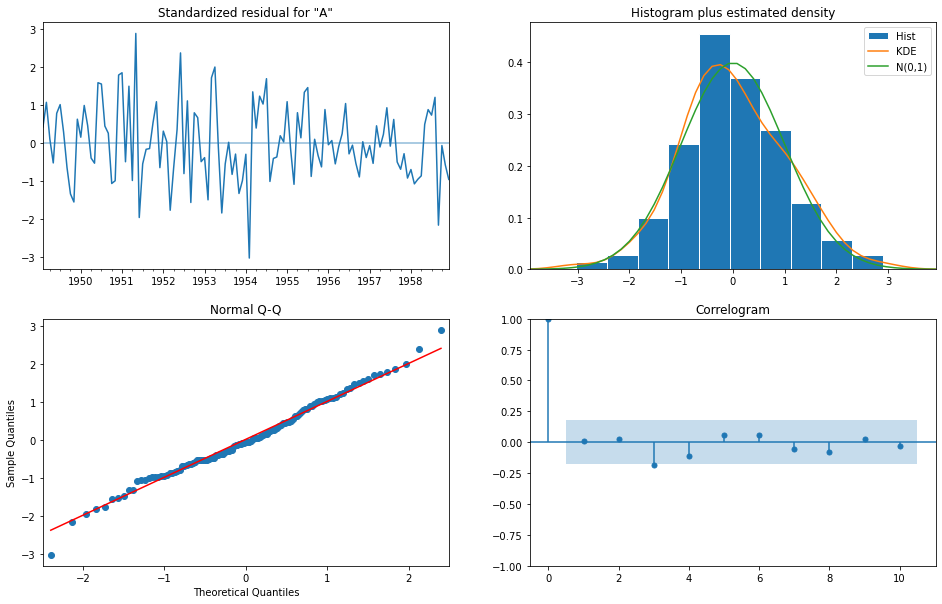

In [83]:
# modèle retenu
res = SARIMAX(y_train, order=(0,1,1), seasonal_order=(1,0,1,12)).fit(disp=False)

# summary
print(res.aic)
print(res.summary())

# résidus
res.plot_diagnostics(figsize=(16, 10));
print("Test de Shapiro :", shapiro(res.resid[13:]))

**Exo :** prédire à partir du modèle retenu les 2 années 1959 et 1960 et afficher sur un même graphique la série originale, les prédictions et l'intervalle de confiance.

<Figure size 1368x504 with 0 Axes>

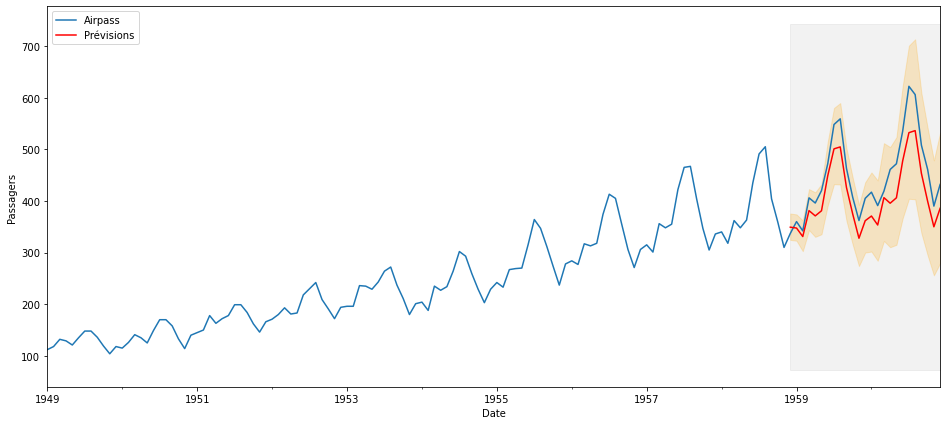

In [84]:
# prédiction et intervalles de confiance
y_pred = res.get_prediction(start=pd.to_datetime('1958-12-01'), end=pd.to_datetime('1960-12-01'))
x_pred = np.exp(y_pred.predicted_mean)
pred_CI = np.exp(y_pred.conf_int())

# affichage
fig = plt.figure(figsize=(19, 7))
ax = x['1949':].plot(label='Série observée');
x_pred.plot(ax=ax, label='Prévisions', color='red');

# affichage de l'intervalle de confiance
ax.fill_between(pred_CI.index, 
                pred_CI.iloc[:, 0], 
                pred_CI.iloc[:, 1], color='orange', alpha=.2);

# un peu de style
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-12-01'), x.index[-1], alpha=.1, zorder=-1, color='grey');
ax.set_xlabel('Date');
ax.set_ylabel('Passagers');
plt.legend(loc='upper left');
plt.show()

**Exo :** évaluer la qualité prédictive du modèle via RMSE et MAPE.

In [85]:
rmse = np.sqrt(((x_test-x_pred)**2).mean())
mape = (np.abs(1-x_pred/x_test)).mean()*100
print("RMSE = {} et MAPE = {}".format(rmse, mape))

RMSE = 47.11786986382568 et MAPE = 9.220540274482797


**Exo :** faire une prévision à long terme  
À l'aide d'un processus ARIMA saisonnier basé sur toute la série temporelle (on modélise toujours la série logarithmique), prédire les 10 années suivantes : déterminer les paramètres du modèle optimal par recherche sur grille.  
Afficher les graphiques qui vous paraissent utiles et intéressants.

```python
from statsmodels.tsa.statespace.sarimax import *
import sys
import itertools
from ipywidgets import IntProgress
from IPython.display import display
import warnings
warnings.filterwarnings(action='ignore')

# valeurs possibles des paramètres
max_param = 3
p = d = q = P = D = Q = range(max_param)

# barre de progression
progressbar = IntProgress(min=0, max=max_param**6)
display(progressbar)

best_aic = np.inf
best_pdq = None
best_PDQ = None
tmp_model = None
best_model = None

for p,d,q,P,D,Q in itertools.product(p, d, q, P, D, Q):
    try:
        tmp_model = SARIMAX(y,
                            order = (p,d,q),
                            seasonal_order = (P,D,Q,12),
                            enforce_stationarity=True,
                            enforce_invertibility=True)
        res = tmp_model.fit()
        
        progressbar.value += 1 #signal pour augmenter la barre de progression

        if res.aic < best_aic:
            best_aic = res.aic
            best_pdq = (p,d,q)
            best_PDQ = (P,D,Q)
            best_model = tmp_model
    except:
        #print("Erreur:", sys.exc_info()[1])
        continue
            
print("Modèle retenu : SARIMA{}{}12 - AIC:{}".format(best_pdq, best_PDQ, best_aic))
```

/home/elka/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/elka/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


-499.31610812523667
                                     SARIMAX Results                                      
Dep. Variable:                            Airpass   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 253.658
Date:                            Wed, 29 Jun 2022   AIC                           -499.316
Time:                                    11:11:03   BIC                           -487.465
Sample:                                01-01-1949   HQIC                          -494.500
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3554      0.070     -5.069      0.000      -0.493      -0.218
ar.S.L12       

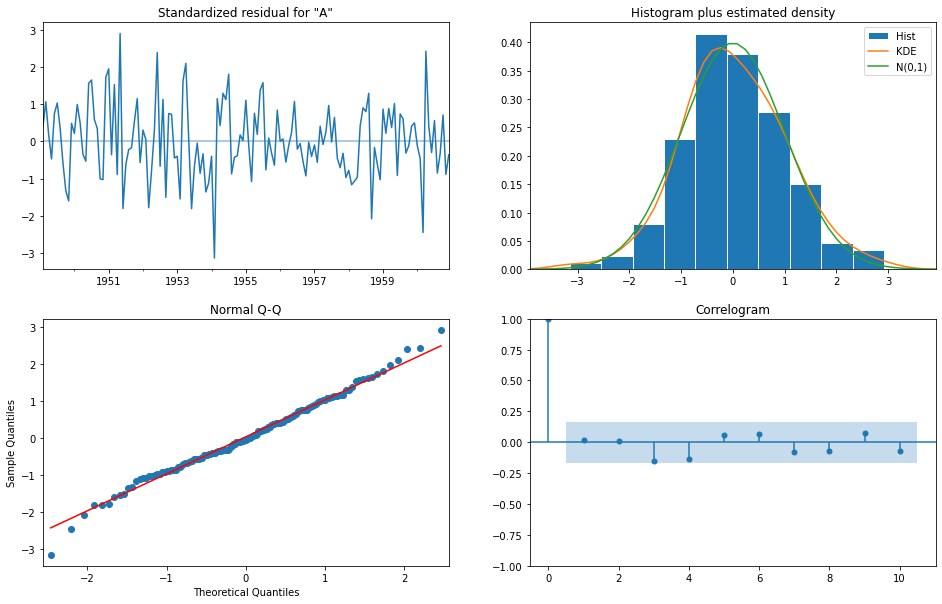

In [86]:
# modèle retenu
res = SARIMAX(y, order=(0,1,1), seasonal_order=(1,0,1,12)).fit(disp=False)

# summary
print(res.aic)
print(res.summary())

# résidus
res.plot_diagnostics(figsize=(16, 10));
print("Test de Shapiro :", shapiro(res.resid[13:]))

# prédiction et intervalles de confiance
y_pred = res.get_forecast(steps=120)
x_pred = np.exp(y_pred.predicted_mean)
pred_CI = np.exp(y_pred.conf_int(alpha=0.05))

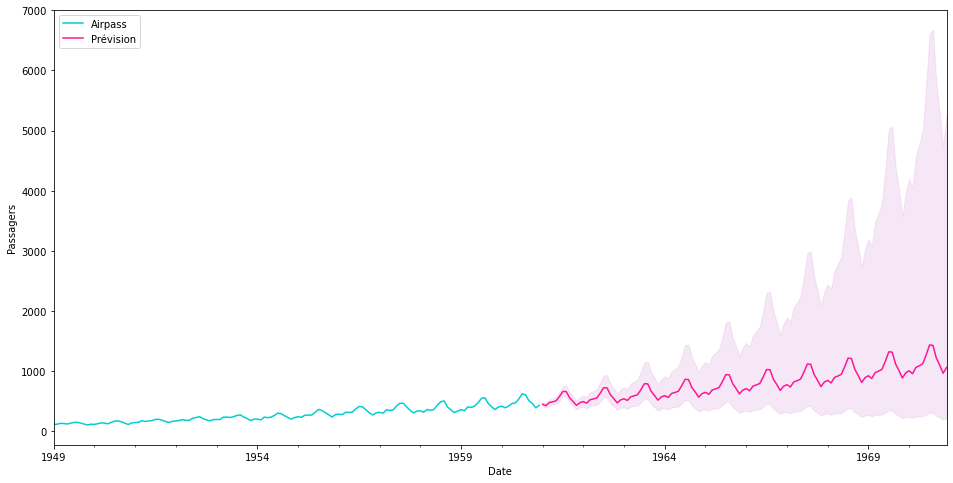

In [87]:
# affichage
ax = x.plot(label='Observés', figsize=(16, 8), color='darkturquoise');
x_pred.plot(ax=ax, label='Prévision', color='deeppink')
ax.fill_between(pred_CI.index,
                pred_CI.iloc[:, 0],
                pred_CI.iloc[:, 1], color='plum', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Passagers');
plt.legend(loc='upper left')
plt.show()

/home/elka/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/elka/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/elka/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                              Airpass   No. Observations:                  144
Model:             SARIMAX(2, 1, 3)x(1, 2, [1], 12)   Log Likelihood                -461.981
Date:                              Wed, 29 Jun 2022   AIC                            939.961
Time:                                      11:12:00   BIC                            962.194
Sample:                                  01-01-1949   HQIC                           948.990
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0374      0.125      0.298      0.765      -0.208       0.283
ar.L2         -0.79

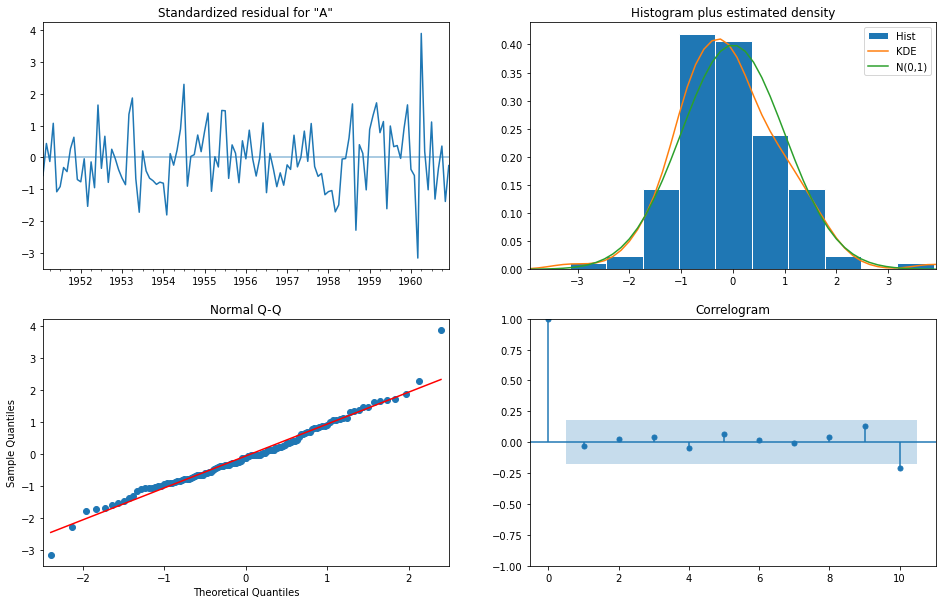

In [88]:
# modèle retenu
res = SARIMAX(x, order=(2,1,3), seasonal_order=(1,2,1,12)).fit(disp=False)

# summary
print(res.summary())

# résidus
res.plot_diagnostics(figsize=(16, 10));
print("Test de Shapiro :", shapiro(res.resid[13:]))

# prédiction et intervalles de confiance
x_pred = res.get_forecast(steps=120)
pred_CI = x_pred.conf_int(alpha=0.05)

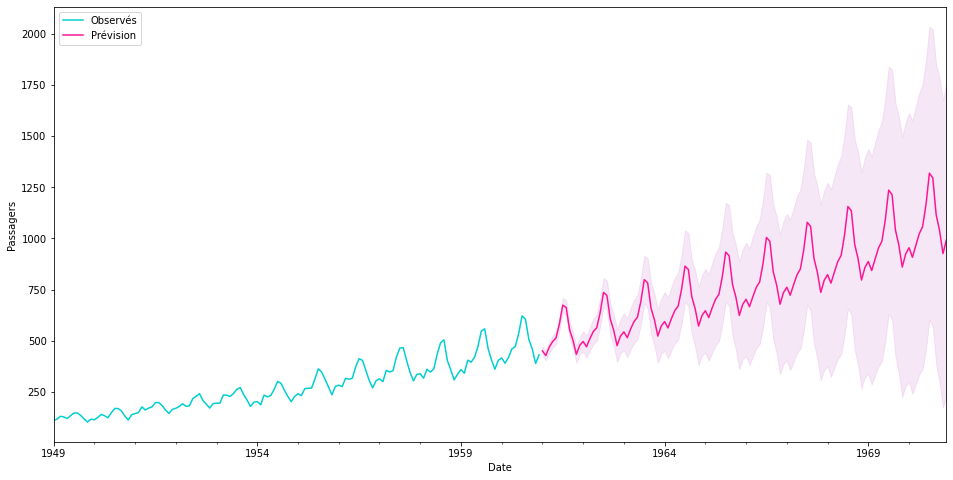

In [58]:
# affichage
ax = x.plot(label='Observés', figsize=(16, 8), color='darkturquoise');
x_pred.predicted_mean.plot(ax=ax, label='Prévision', color='deeppink')
ax.fill_between(pred_CI.index,
                pred_CI.iloc[:, 0],
                pred_CI.iloc[:, 1], color='plum', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Passagers');
plt.legend(loc='upper left')
plt.show()